# 1. Install Packages

In [1]:
#Install packages
install.packages(c("dplyr","ggplot2", "ordinal","emmeans","broom","writexl"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ucminf’, ‘numDeriv’, ‘estimability’, ‘mvtnorm’




# 2. Data Analysis

## Import Libraries

In [2]:
library(dplyr)
library(ggplot2)
library(ordinal)
library(emmeans)
library(readr)
library(tidyr)
library(grid)
library(scales)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘ordinal’


The following object is masked from ‘package:dplyr’:

    slice


Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'


Attaching package: ‘scales’


The following object is masked from ‘package:readr’:

    col_factor




## RFC

### Setup Data

In [3]:
# Read the data
df <- read.csv("https://raw.githubusercontent.com/MatthewCGalbraith/GrammarHCI/refs/heads/main/scoresnoncondensedlong.csv",
               na.strings = c("", "NA"))

# Keep only RFC items
df_rfc <- df %>% filter(grepl("^RFC[A-D]", Question))

# Coerce Scores to character then keep only Likert 1–5; drop 0 / NA
df_rfc <- df_rfc %>%
  mutate(Scores = as.character(Scores)) %>%
  filter(Scores %in% c("1","2","3","4","5")) %>%
  mutate(Scores = ordered(Scores, levels = c("1","2","3","4","5")))

# Map item prefix to condition
df_rfc <- df_rfc %>%
  mutate(
    condition = case_when(
      grepl("^RFCA", Question) ~ "Int",
      grepl("^RFCB", Question) ~ "RFCi",
      grepl("^RFCC", Question) ~ "RFCp",
      grepl("^RFCD", Question) ~ "Dec",
      TRUE ~ NA_character_
    ),
    # Set publication order for your hierarchy display
    condition = factor(condition, levels = c("Int","RFCp","Dec","RFCi"))
  )

# Assumes pattern like RFCA1, RFCB1, RFCC1, RFCD1 share base item "1"
df_rfc <- df_rfc %>%
  mutate(item_base = factor(gsub("^RFC[A-D]([0-9]+).*$", "\\1", Question)))

# Rename item labels for plotting/tables while keeping original question
df_rfc <- df_rfc %>%
  mutate(Question_renamed = Question |>
           sub("^RFCA", "Int",  x = _) |>
           sub("^RFCB", "RFCi", x = _) |>
           sub("^RFCC", "RFCp", x = _) |>
           sub("^RFCD", "Dec",  x = _))

# Verify the df structure
table(df_rfc$item_base, df_rfc$condition)


   
    Int RFCp Dec RFCi
  1 200  200 200  200
  2 200  200 200  200
  3 200  200 200  200
  4 200  200 200  200
  5 200  200 200  200

### Frequency Table


In [4]:
df_frequency_table <- df_rfc %>%
  group_by(condition, Scores) %>%
  summarise(Frequency = n(), .groups = 'drop')

print(df_frequency_table)

# A tibble: 20 × 3
   condition Scores Frequency
   <fct>     <ord>      <int>
 1 Int       1             69
 2 Int       2            109
 3 Int       3             95
 4 Int       4            248
 5 Int       5            479
 6 RFCp      1            124
 7 RFCp      2            271
 8 RFCp      3            166
 9 RFCp      4            314
10 RFCp      5            125
11 Dec       1            151
12 Dec       2            304
13 Dec       3            205
14 Dec       4            244
15 Dec       5             96
16 RFCi      1            171
17 RFCi      2            416
18 RFCi      3            131
19 RFCi      4            234
20 RFCi      5             48


### Stacked Bar Chart with Counts

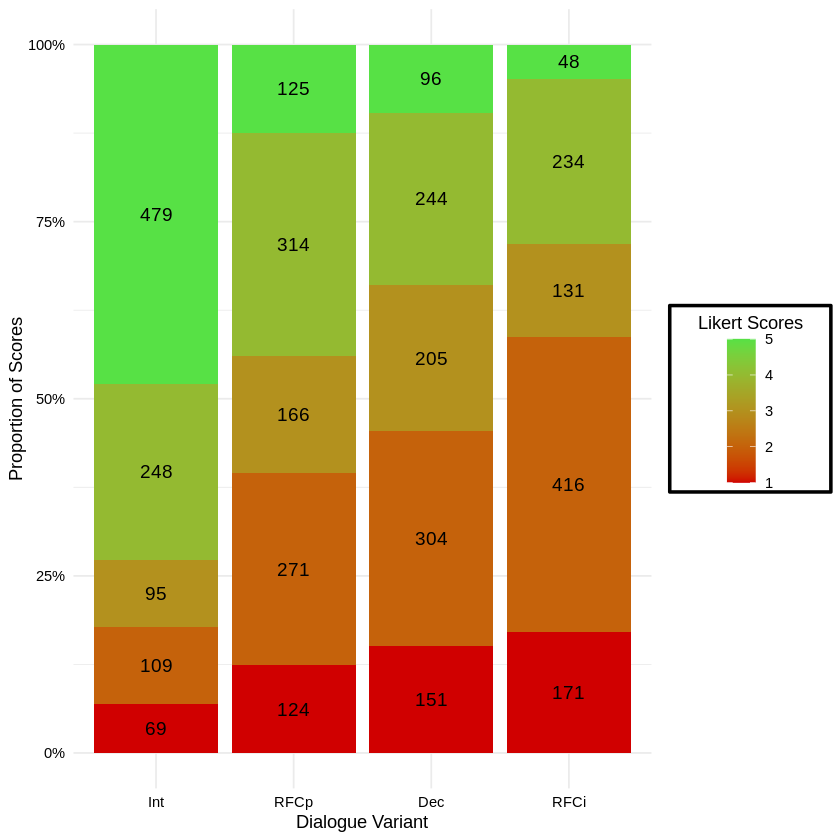

In [5]:
# Calculate proportions of Scores within each condition
df_proportions <- df_rfc %>%
  group_by(condition, Scores) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(condition) %>%
  mutate(proportion = count / sum(count)) %>%
  ungroup()

# Convert Scores to numeric for gradient
df_proportions$Scores_numeric <- as.numeric(as.character(df_proportions$Scores))

# Create the 100% stacked bar chart with counts as labels
ggplot(df_proportions, aes(x = condition, y = proportion, fill = Scores_numeric)) +
  geom_bar(stat = "identity", position = "fill") +
  geom_text(aes(label = count),
            position = position_fill(vjust = 0.5),
            color = "black", size = 4) +
  scale_y_continuous(labels = scales::percent) +
  labs(
    x = "Dialogue Variant",
    y = "Proportion of Scores",
    fill = "Likert Scores"
  ) +
  scale_fill_gradient(low = "#d00000", high = "#57e145",
                      breaks = 1:5,
                      labels = as.character(1:5)) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 0, hjust = 0.5, color = "black"),
    axis.text.y = element_text(color = "black"),
    axis.title.x = element_text(color = "black"),
    axis.title.y = element_text(color = "black"),
    legend.position = "right",
    legend.title = element_text(color = "black", hjust = 0.5),
    legend.text = element_text(color = "black"),
    legend.background = element_rect(color = "black", linewidth = 1),
    legend.justification = "center",
    legend.box.just = "center"
  )


### EMMeans Analysis


#### P-Value Formatting

In [6]:
# Define p-value formatting function
format_pval <- function(p_value) {
  if (p_value < 0.001) {
    return("<0.001***")
  } else if (p_value < 0.01) {
    return("<0.01**")
  } else if (p_value < 0.05) {
    return("<0.05*")
  } else {
    return(paste0("", round(p_value, 4)))
  }
}

#### EMMeans

In [7]:
df_rfc$Participant <- factor(df_rfc$Participant)

# Model WITH item fixed effects
m_rfc <- ordinal::clmm(Scores ~ condition + item_base + (1 | Participant), data = df_rfc, link = "logit", Hess = TRUE)

# Latent EMMeans with CIs (averages over items)
emm_latent_rfc <- emmeans(m_rfc, ~ condition, mode = "latent")
latent_rfc_tbl <- as.data.frame(summary(emm_latent_rfc, infer = c(TRUE, TRUE)))

# Format the table
# Create a new data frame to ensure no lingering 'summary_emm' class attributes
latent_rfc_tbl_formatted <- data.frame(latent_rfc_tbl)

# Round numeric columns to 2 decimal places (except p-values)
for (col in names(latent_rfc_tbl_formatted)) {
  if (is.numeric(latent_rfc_tbl_formatted[[col]]) && !grepl("p.value|p_value|pval", col, ignore.case = TRUE)) {
    latent_rfc_tbl_formatted[[col]] <- round(latent_rfc_tbl_formatted[[col]], 2)
  }
}

# Format p-values if they exist (after other numeric rounding)
if ("p.value" %in% names(latent_rfc_tbl_formatted)) {
  latent_rfc_tbl_formatted$p.value <- sapply(latent_rfc_tbl_formatted$p.value, format_pval)
}

write.csv(latent_rfc_tbl_formatted, "RFC-emmeans.csv", row.names = FALSE)
print(latent_rfc_tbl_formatted)

  condition emmean   SE  df asymp.LCL asymp.UCL z.ratio   p.value
1       Int   1.91 0.11 Inf      1.70      2.12   17.76 <0.001***
2      RFCp   0.06 0.10 Inf     -0.13      0.26    0.64    0.5191
3       Dec  -0.27 0.10 Inf     -0.46     -0.07   -2.71   <0.01**
4      RFCi  -0.70 0.10 Inf     -0.90     -0.50   -6.95 <0.001***


### Pairwise Comparison


In [8]:
# All pairwise condition contrasts on latent scale with adjustments
pairs_holm_rfc <- pairs(emm_latent_rfc, adjust = "holm")
pairs_holm_tbl <- as.data.frame(summary(pairs_holm_rfc, infer = c(TRUE, TRUE)))

# Format the table
# Create a new data frame to ensure no lingering 'summary_emm' class attributes
pairs_holm_tbl_formatted <- data.frame(pairs_holm_tbl)

# Round numeric columns to 2 decimal places (except p-values)
for (col in names(pairs_holm_tbl_formatted)) {
  if (is.numeric(pairs_holm_tbl_formatted[[col]]) && !grepl("p.value|p_value|pval", col, ignore.case = TRUE)) {
    pairs_holm_tbl_formatted[[col]] <- round(pairs_holm_tbl_formatted[[col]], 2)
  }
}

# Format p-values if they exist (after other numeric rounding)
if ("p.value" %in% names(pairs_holm_tbl_formatted)) {
  pairs_holm_tbl_formatted$p.value <- sapply(pairs_holm_tbl_formatted$p.value, format_pval)
}

write.csv(pairs_holm_tbl_formatted, "RFC-pairwise.csv", row.names = FALSE)
print(pairs_holm_tbl_formatted)

     contrast estimate   SE  df asymp.LCL asymp.UCL z.ratio   p.value
1  Int - RFCp     1.84 0.09 Inf      1.60      2.08   20.32 <0.001***
2   Int - Dec     2.18 0.09 Inf      1.93      2.42   23.75 <0.001***
3  Int - RFCi     2.61 0.10 Inf      2.36      2.86   27.43 <0.001***
4  RFCp - Dec     0.33 0.08 Inf      0.12      0.55    4.13 <0.001***
5 RFCp - RFCi     0.77 0.08 Inf      0.55      0.98    9.23 <0.001***
6  Dec - RFCi     0.43 0.08 Inf      0.22      0.65    5.28 <0.001***


### Pairwise Comparison Estimates


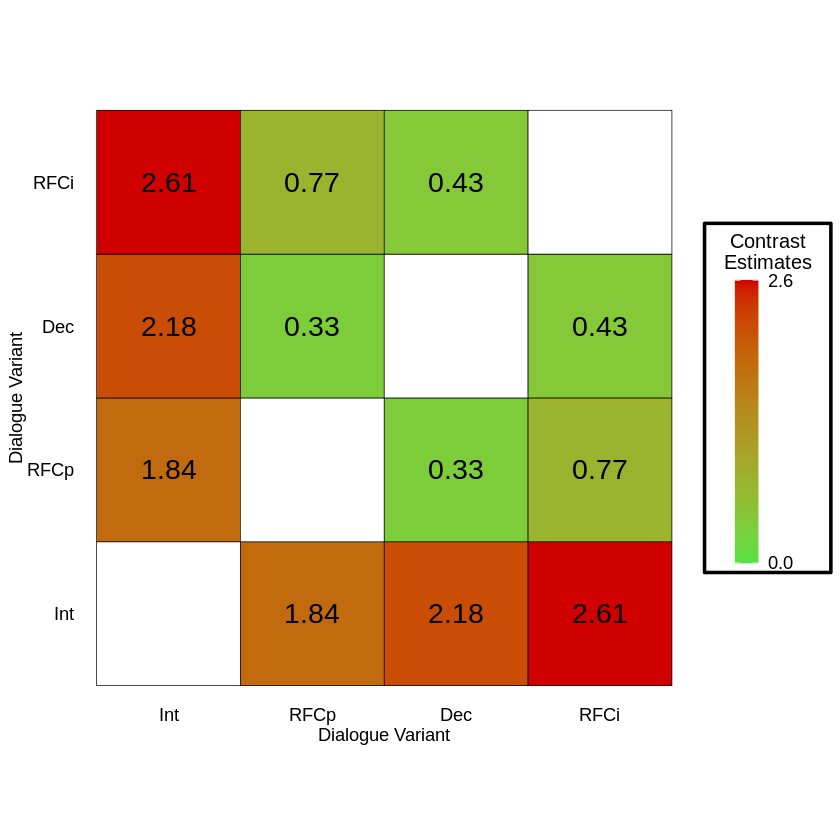

In [9]:
results <- summary(pairs_holm_rfc)
df_contrasts <- as.data.frame(results)

format_pvalue <- function(p_value) {
  if (p_value < 0.001) {
    return("<0.001***")
  } else if (p_value < 0.01) {
    return("<0.01**")
  } else if (p_value < 0.05) {
    return("<0.05*")
  } else {
    return(paste0("", round(p_value, 4)))
  }
}

df_pairwise <- data.frame(
  Effect = df_contrasts$contrast,
  Coefficient = round(df_contrasts$estimate, 2),
  `Std. Error` = round(df_contrasts$SE, 2),
  `Z Value` = round(df_contrasts$z.ratio, 2),
  `P Value` = sapply(df_contrasts$p.value, format_pvalue),
  Odds_Ratio = round(exp(df_contrasts$estimate), 2),
  CI_Lower = round(exp(df_contrasts$estimate - 1.96 * df_contrasts$SE), 2),
  CI_Upper = round(exp(df_contrasts$estimate + 1.96 * df_contrasts$SE), 2)
)

all_conditions <- c("Int","RFCp","Dec","RFCi")

df_heat_prep <- df_pairwise %>%
  mutate(Effect = as.character(Effect)) %>%
  separate(Effect, into = c("Condition1", "Condition2"), sep = " - ", remove = FALSE) %>%
  rename(estimate = Coefficient) %>%
  select(Condition1, Condition2, estimate)

df_heat_full <- expand.grid(
  Condition1 = all_conditions,
  Condition2 = all_conditions,
  stringsAsFactors = FALSE
) %>%
  left_join(df_heat_prep, by = c("Condition1", "Condition2")) %>%
  mutate(
    estimate = ifelse(
      is.na(estimate),
      df_heat_prep$estimate[
        match(
          paste(Condition2, Condition1, sep = " - "),
          paste(df_heat_prep$Condition1, df_heat_prep$Condition2, sep = " - ")
        )
      ],
      estimate
    )
  ) %>%
  mutate(estimate = ifelse(Condition1 == Condition2, NA, estimate)) %>%
  mutate(
    x = factor(Condition1, levels = all_conditions),
    y = factor(Condition2, levels = all_conditions)
  )


ggplot(df_heat_full, aes(x = x, y = y, fill = estimate)) +
  geom_tile(color = "black") +
  geom_text(aes(label = round(estimate, 2)), size = 6, na.rm = TRUE) +
  scale_fill_gradient(
    name = "Contrast\nEstimates",
    low = "#57e145",
    high = "#d00000",
    limits = c(0.0, 2.6),
    oob = scales::squish,
    na.value = "white",
    breaks = c(0.0, 2.6),
    labels = c("0.0", "2.6")
  ) +
  coord_fixed() +
  labs(
    x = "Dialogue Variant",
    y = "Dialogue Variant"
  ) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text = element_text(size = 11, color = "black"),
    legend.title = element_text(size = 12, hjust = 0.5),
    legend.text = element_text(size = 11),
    legend.background = element_rect(color = "black", linewidth = 1),
    legend.key.height = unit(1.2, "cm"),
    legend.key.width = unit(0.5, "cm"),
    legend.spacing.y = unit(0.2, "cm")
  )

### EMMeans Plot


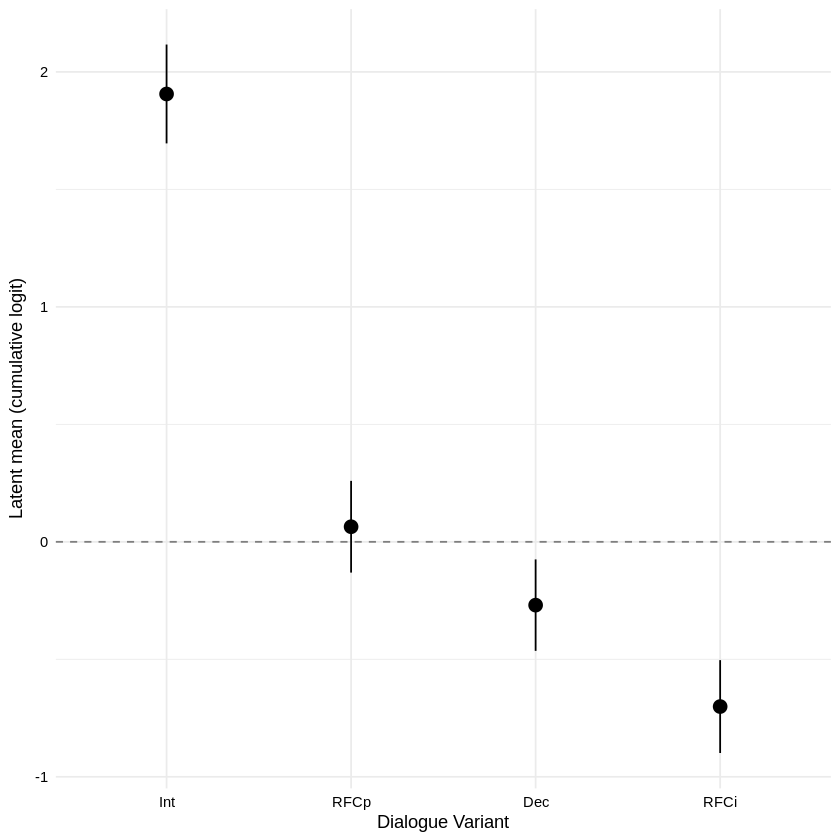

In [10]:
# assuming latent_tbl has columns: condition, emmean, asymp.LCL, asymp.UCL
latent_rfc_tbl$condition <- factor(latent_rfc_tbl$condition, levels = c("Int","RFCp","Dec","RFCi"))

ggplot(latent_rfc_tbl, aes(x = condition, y = emmean)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey50") +
  geom_pointrange(aes(ymin = asymp.LCL, ymax = asymp.UCL), size = 0.7) +
  labs(x = "Dialogue Variant", y = "Latent mean (cumulative logit)") +
  theme_minimal() +
  theme(
    text = element_text(color = "black"),
    axis.title = element_text(color = "black"),
    axis.text = element_text(color = "black"),
    legend.text = element_text(color = "black"),
    legend.title = element_text(color = "black"),
    plot.title = element_text(color = "black")
  )

### Pairwise Comparison Summary


In [11]:
# Get the summary of the pairwise comparisons
results <- summary(pairs_holm_rfc)

# Convert the results to a dataframe
df_contrasts <- as.data.frame(results)

# Create a function to format P values
format_pvalue <- function(p_value) {
  if (p_value < 0.001) {
    return("<0.001***")
  } else if (p_value < 0.01) {
    return("<0.01**")
  } else if (p_value < 0.05) {
    return("<0.05*")
  } else {
    return(paste0("", round(p_value, 4)))
  }
}

# Create dataframe for pairwise comparisons
df_pairwise <- data.frame(
  Effect = df_contrasts$contrast,
  Coefficient = round(df_contrasts$estimate, 2),
  `Std. Error` = round(df_contrasts$SE, 2),
  `Z Value` = round(df_contrasts$z.ratio, 2),
  `P Value` = sapply(df_contrasts$p.value, format_pvalue),
  Odds_Ratio = round(exp(df_contrasts$estimate), 2),
  CI_Lower = round(exp(df_contrasts$estimate - 1.96 * df_contrasts$SE), 2),
  CI_Upper = round(exp(df_contrasts$estimate + 1.96 * df_contrasts$SE), 2)
)

# Print the new pairwise dataframe
print(df_pairwise)

       Effect Coefficient Std..Error Z.Value   P.Value Odds_Ratio CI_Lower
1  Int - RFCp        1.84       0.09   20.32 <0.001***       6.31     5.28
2   Int - Dec        2.18       0.09   23.75 <0.001***       8.81     7.36
3  Int - RFCi        2.61       0.10   27.43 <0.001***      13.56    11.25
4  RFCp - Dec        0.33       0.08    4.13 <0.001***       1.40     1.19
5 RFCp - RFCi        0.77       0.08    9.23 <0.001***       2.15     1.83
6  Dec - RFCi        0.43       0.08    5.28 <0.001***       1.54     1.31
  CI_Upper
1     7.53
2    10.54
3    16.34
4     1.64
5     2.53
6     1.81


### Pairwise Comparison P-Values


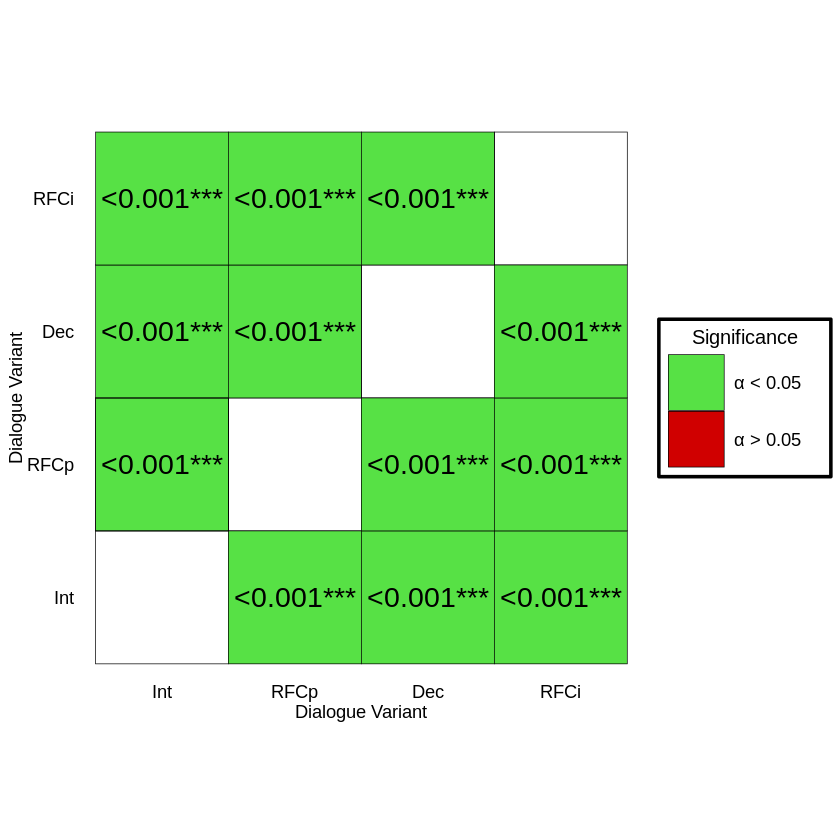

In [12]:
# FORCE exact order - override everything
cond_order <- factor(c("Int", "RFCp", "Dec", "RFCi"), levels = c("Int", "RFCp", "Dec", "RFCi"))

# Prepare pairwise data - convert to character FIRST to break factor inheritance
df_pairs <- df_pairwise %>%
  mutate(
    Effect = as.character(Effect),  # CRITICAL: break factor
    x = sapply(strsplit(Effect, " - "), `[`, 1),
    y = sapply(strsplit(Effect, " - "), `[`, 2),
    Significance = ifelse(gsub("[^0-9.]", "", P.Value) < 0.05, "α < 0.05", "α > 0.05")
  ) %>%
  select(x, y, P.Value, Significance)

# Create full symmetric matrix using ONLY our order
df_full <- expand.grid(
  x = cond_order,
  y = cond_order,
  stringsAsFactors = FALSE
) %>%
  left_join(df_pairs, by = c("x", "y")) %>%
  left_join(
    df_pairs %>%
      mutate(x = as.character(x), y = as.character(y)) %>%  # ensure character join keys
      rename(x = y, y = x, P.Value2 = P.Value, Significance2 = Significance),
    by = c("x", "y")
  ) %>%
  mutate(
    P.Value = coalesce(P.Value, P.Value2),
    Significance = coalesce(Significance, Significance2),
    # FORCE factor levels - no inheritance
    x = factor(x, levels = cond_order),
    y = factor(y, levels = cond_order),
    EmptyCell = x == y
  )

# Rest unchanged...
if (!"α > 0.05" %in% df_full$Significance) {
  dummy_row <- data.frame(
    x = cond_order[1], y = cond_order[2], P.Value = NA,
    Significance = factor("α > 0.05", levels = c("α < 0.05", "α > 0.05")),
    EmptyCell = FALSE
  )
  df_full <- bind_rows(df_full, dummy_row)
}

ggplot(df_full, aes(x = x, y = y)) +
  geom_tile(data = subset(df_full, EmptyCell), fill = "white", color = "black") +
  geom_tile(data = subset(df_full, !EmptyCell), aes(fill = Significance, alpha = !is.na(P.Value)), color = "black") +
  geom_text(data = subset(df_full, !EmptyCell & !is.na(P.Value)), aes(label = P.Value), size = 6, color = "black") +
  scale_fill_manual(values = c("α < 0.05" = "#57e145", "α > 0.05" = "#d00000"), name = "Significance", drop = FALSE) +
  scale_alpha_identity() +
  coord_fixed() +
  guides(fill = guide_legend(override.aes = list(shape = 22, size = 6, color = "black", alpha = 1))) +
  labs(x = "Dialogue Variant", y = "Dialogue Variant") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text = element_text(size = 11, color = "black"),
    legend.title = element_text(size = 12, hjust = 0.5),
    legend.text = element_text(size = 11),
    legend.background = element_rect(color = "black", linewidth = 1),
    legend.key.height = unit(1.2, "cm"),
    legend.key.width = unit(1.2, "cm"),
    legend.spacing.y = unit(0.2, "cm")
  )


## OIR

### Setup Data

In [13]:
# Read
df <- read.csv("https://raw.githubusercontent.com/MatthewCGalbraith/GrammarHCI/refs/heads/main/scoresnoncondensedlong.csv",
               na.strings = c("", "NA"))

# Keep OIR items
df_oir <- df %>% filter(grepl("^OIR[A-B]", Question))

# Scores as ordered 1..5; drop 0/NA
df_oir <- df_oir %>%
  mutate(Scores = as.character(Scores)) %>%
  filter(Scores %in% c("1","2","3","4","5")) %>%
  mutate(Scores = ordered(Scores, levels = c("1","2","3","4","5")))

# Map items to condition
df_oir <- df_oir %>%
  mutate(
    condition = case_when(
      grepl("^OIRA", Question) ~ "OIRi",
      grepl("^OIRB", Question) ~ "OIRp",
      TRUE ~ NA_character_
    ),
    condition = factor(condition, levels = c("OIRp","OIRi"))
  )

## Removes the Reasoning Questions from OIR
# Keep only A-variants and extract numeric item ID (1–5)
df_oir <- df_oir %>%
  filter(grepl("A$", Question)) %>%
  mutate(item_base = factor(gsub("^OIR[AB]([0-9]+)A$", "\\1", Question)))

# Verify structure: each item should appear in both conditions
table(df_oir$item_base, df_oir$condition)

   
    OIRp OIRi
  1  200  200
  2  200  200
  3  200  200
  4  200  200
  5  200  200

### Frequency Table

In [14]:
df_frequency_table <- df_oir %>%
  group_by(condition, Scores) %>%
  summarise(Frequency = n(), .groups = 'drop')

print(df_frequency_table)

# A tibble: 10 × 3
   condition Scores Frequency
   <fct>     <ord>      <int>
 1 OIRp      1             22
 2 OIRp      2            150
 3 OIRp      3             99
 4 OIRp      4            471
 5 OIRp      5            258
 6 OIRi      1             23
 7 OIRi      2            171
 8 OIRi      3            100
 9 OIRi      4            472
10 OIRi      5            234


### Stacked Bar Chart with Counts

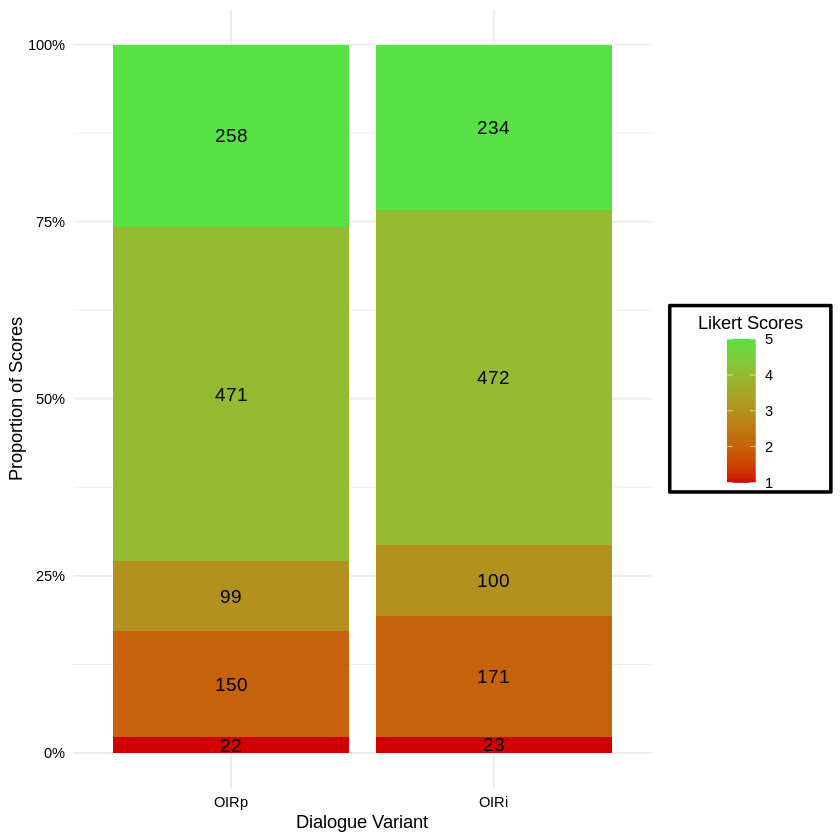

In [15]:
# Calculate proportions
df_proportions <- df_oir %>%
  group_by(condition, Scores) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(condition) %>%
  mutate(proportion = count / sum(count)) %>%
  ungroup()

# Convert Scores to numeric for gradient
df_proportions$Scores_numeric <- as.numeric(as.character(df_proportions$Scores))

# Create the 100% stacked bar chart with counts as labels
ggplot(df_proportions, aes(x = condition, y = proportion, fill = Scores_numeric)) +
  geom_bar(stat = "identity", position = "fill") +
  geom_text(aes(label = count),
            position = position_fill(vjust = 0.5),  # centers the text in each stacked segment
            color = "black", size = 4) +
  scale_y_continuous(labels = scales::percent) +
  labs(
    x = "Dialogue Variant",
    y = "Proportion of Scores",
    fill = "Likert Scores"
  ) +
  scale_fill_gradient(low = "#d00000", high = "#57e145",
                      breaks = 1:5,
                      labels = as.character(1:5)) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 0, hjust = 0.5, color = "black"),
    axis.text.y = element_text(color = "black"),
    axis.title.x = element_text(color = "black"),
    axis.title.y = element_text(color = "black"),
    legend.position = "right",
    legend.title = element_text(color = "black", hjust = 0.5),
    legend.text = element_text(color = "black"),
    legend.background = element_rect(color = "black", linewidth = 1),
    legend.justification = "center",
    legend.box.just = "center"
  )


### EMMeans Analysis

#### P-Value Formatting

In [16]:
# Define p-value formatting function
format_pval <- function(p_value) {
  if (p_value < 0.001) {
    return("<0.001***")
  } else if (p_value < 0.01) {
    return("<0.01**")
  } else if (p_value < 0.05) {
    return("<0.05*")
  } else {
    return(paste0("", round(p_value, 4)))
  }
}

#### EMMeans

In [17]:
df_oir$Participant <- factor(df_oir$Participant)

# Model WITH item fixed effects
m_oir <- ordinal::clmm(Scores ~ condition + item_base + (1 | Participant), data = df_oir, link = "logit", Hess = TRUE)

# Latent EMMeans with CIs (averages over items)
emm_latent_oir <- emmeans(m_oir, ~ condition, mode = "latent")
latent_oir_tbl <- as.data.frame(summary(emm_latent_oir, infer = c(TRUE, TRUE)))

# Format the table
# Create a new data frame to ensure no lingering 'summary_emm' class attributes
latent_oir_tbl_formatted <- data.frame(latent_oir_tbl)

# Round numeric columns to 2 decimal places (except p-values)
for (col in names(latent_oir_tbl_formatted)) {
  if (is.numeric(latent_oir_tbl_formatted[[col]]) && !grepl("p.value|p_value|pval", col, ignore.case = TRUE)) {
    latent_oir_tbl_formatted[[col]] <- round(latent_oir_tbl_formatted[[col]], 2)
  }
}

# Format p-values if they exist (after other numeric rounding)
if ("p.value" %in% names(latent_oir_tbl_formatted)) {
  latent_oir_tbl_formatted$p.value <- sapply(latent_oir_tbl_formatted$p.value, format_pval)
}

write.csv(latent_oir_tbl_formatted, "OIR-emmeans.csv", row.names = FALSE)
print(latent_oir_tbl_formatted)

  condition emmean   SE  df asymp.LCL asymp.UCL z.ratio   p.value
1      OIRp   1.86 0.14 Inf      1.57      2.14   12.92 <0.001***
2      OIRi   1.72 0.14 Inf      1.44      2.00   12.04 <0.001***


### Pairwise Comparison

In [18]:
# All pairwise condition contrasts on latent scale with adjustments
pairs_holm_oir  <- pairs(emm_latent_oir, adjust = "holm")
pairs_holm_tbl  <- as.data.frame(summary(pairs_holm_oir, infer = c(TRUE, TRUE)))

# Format the table
# Create a new data frame to ensure no lingering 'summary_emm' class attributes
pairs_holm_tbl_formatted <- data.frame(pairs_holm_tbl)

# Round numeric columns to 2 decimal places (except p-values)
for (col in names(pairs_holm_tbl_formatted)) {
  if (is.numeric(pairs_holm_tbl_formatted[[col]]) && !grepl("p.value|p_value|pval", col, ignore.case = TRUE)) {
    pairs_holm_tbl_formatted[[col]] <- round(pairs_holm_tbl_formatted[[col]], 2)
  }
}

# Format p-values if they exist (after other numeric rounding)
if ("p.value" %in% names(pairs_holm_tbl_formatted)) {
  pairs_holm_tbl_formatted$p.value <- sapply(pairs_holm_tbl_formatted$p.value, format_pval)
}

write.csv(pairs_holm_tbl_formatted, "OIR-pairwise.csv", row.names = FALSE)
print(pairs_holm_tbl_formatted)

     contrast estimate   SE  df asymp.LCL asymp.UCL z.ratio p.value
1 OIRp - OIRi     0.14 0.09 Inf     -0.04      0.31    1.54  0.1236


### EMMeans Plot

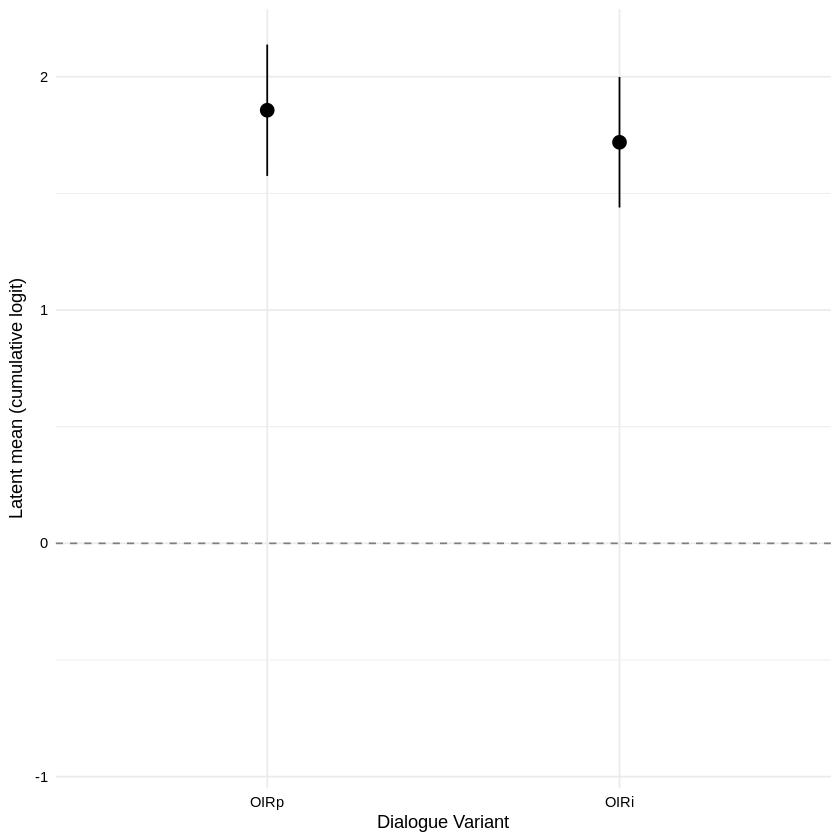

In [19]:
# Calculate y-axis limits across BOTH datasets
ymin_combined <- min(c(latent_oir_tbl$asymp.LCL, latent_rfc_tbl$asymp.LCL))
ymax_combined <- max(c(latent_oir_tbl$asymp.UCL, latent_rfc_tbl$asymp.UCL))

# Plot the chart
latent_oir_tbl$condition <- factor(latent_oir_tbl$condition,
                                   levels = c("OIRp","OIRi"))

ggplot(latent_oir_tbl, aes(x = condition, y = emmean)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey50") +
  geom_pointrange(aes(ymin = asymp.LCL, ymax = asymp.UCL), size = 0.7) +
  labs(x = "Dialogue Variant", y = "Latent mean (cumulative logit)") +
  coord_cartesian(ylim = c(ymin_combined, ymax_combined)) +  # Changed this line
  theme_minimal() +
  theme(
    text = element_text(color = "black"),
    axis.title = element_text(color = "black"),
    axis.text = element_text(color = "black"),
    legend.text = element_text(color = "black"),
    legend.title = element_text(color = "black"),
    plot.title = element_text(color = "black")
  )

### Pairwise Comparison Summary

In [20]:
# Get the summary of the pairwise comparisons for OIR data
results <- summary(pairs_holm_oir, reverse = TRUE)

# Convert the results to a dataframe
df_contrasts <- as.data.frame(results)

# Create a function to format P values
format_pvalue <- function(p_value) {
  if (p_value < 0.001) {
    return("<0.001***")
  } else if (p_value < 0.01) {
    return("<0.01**")
  } else if (p_value < 0.05) {
    return("<0.05*")
  } else {
    return(paste0("", round(p_value, 4)))
  }
}

# Create dataframe for pairwise comparisons
df_pairwise <- data.frame(
  Effect = df_contrasts$contrast,
  Coefficient = round(df_contrasts$estimate, 2),
  `Std. Error` = round(df_contrasts$SE, 2),
  `Z Value` = round(df_contrasts$z.ratio, 2),
  `P Value` = sapply(df_contrasts$p.value, format_pvalue),
  Odds_Ratio = round(exp(df_contrasts$estimate), 2),
  CI_Lower = round(exp(df_contrasts$estimate - 1.96 * df_contrasts$SE), 2),
  CI_Upper = round(exp(df_contrasts$estimate + 1.96 * df_contrasts$SE), 2)
)

# Print the new pairwise dataframe
print(df_pairwise)

       Effect Coefficient Std..Error Z.Value P.Value Odds_Ratio CI_Lower
1 OIRp - OIRi        0.14       0.09    1.54  0.1236       1.15     0.96
  CI_Upper
1     1.37


### Pairwise Comparison P-Values

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


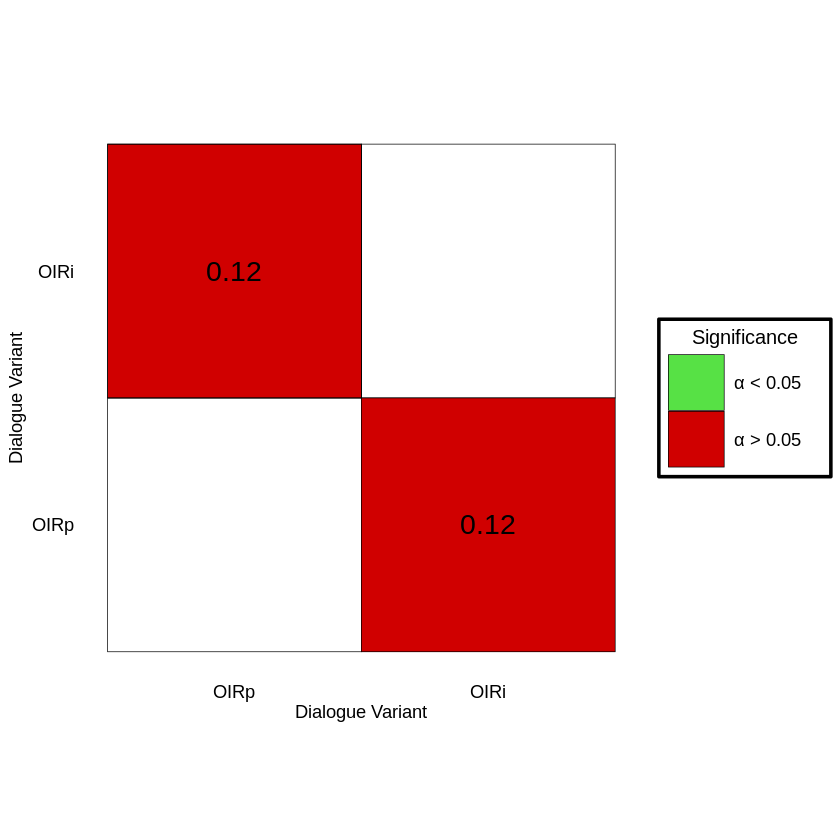

In [21]:
# Automatically get all conditions from your pairwise data
conditions <- unique(c(
  df_pairwise$Effect %>% sapply(function(x) strsplit(x, " - ")[[1]][1]),
  df_pairwise$Effect %>% sapply(function(x) strsplit(x, " - ")[[1]][2])
))

# Prepare pairwise data
df_pairs <- df_pairwise %>%
  mutate(
    x = sapply(strsplit(Effect, " - "), `[`, 1),
    y = sapply(strsplit(Effect, " - "), `[`, 2),

    # Clean P.Value so it's numeric (remove *, spaces, etc.)
    P.Value.cleaned = gsub("[^0-9eE\\.-]", "", P.Value),
    P.Value = as.numeric(P.Value.cleaned),

    # Significance based on presence of *
    Significance = ifelse(grepl("\\*", df_pairwise$P.Value), "α < 0.05", "α > 0.05")
  ) %>%
  select(x, y, P.Value, Significance)

# Create full symmetric matrix
df_full <- expand.grid(
  x = conditions,
  y = conditions,
  stringsAsFactors = FALSE
) %>%
  left_join(df_pairs, by = c("x", "y")) %>%
  left_join(
    df_pairs %>% rename(x = y, y = x, P.Value2 = P.Value, Significance2 = Significance),
    by = c("x", "y")
  ) %>%
  mutate(
    P.Value = coalesce(P.Value, P.Value2),
    Significance = coalesce(Significance, Significance2),
    EmptyCell = x == y
  )

# Ensure both legend levels appear using dummy tiles if needed
required_levels <- c("α < 0.05", "α > 0.05")
missing_levels <- setdiff(required_levels, df_full$Significance)

if (length(missing_levels) > 0) {
  dummy_rows <- data.frame(
    x = conditions[1],
    y = conditions[2],
    P.Value = NA,
    Significance = factor(missing_levels, levels = required_levels),
    EmptyCell = FALSE
  )
  df_full <- bind_rows(df_full, dummy_rows)
}

# ---- Minimal change: force axes order ----
df_full$x <- factor(df_full$x, levels = c("OIRp", "OIRi"))
df_full$y <- factor(df_full$y, levels = c("OIRp", "OIRi"))

df_full$Significance <- factor(df_full$Significance, levels = required_levels)

# Plot symmetric heatmap
ggplot(df_full, aes(x = x, y = y)) +
  geom_tile(data = subset(df_full, EmptyCell),
            fill = "white", color = "black") +
  geom_tile(data = subset(df_full, !EmptyCell),
            aes(fill = Significance, alpha = !is.na(P.Value)),
            color = "black") +
  geom_text(
    data = subset(df_full, !EmptyCell & !is.na(P.Value)),
    aes(label = sprintf("%.2f", P.Value)),
    size = 6,
    color = "black"
  ) +
  scale_fill_manual(
    values = c("α < 0.05" = "#57e145", "α > 0.05" = "#d00000"),
    name = "Significance",
    drop = FALSE
  ) +
  scale_alpha_identity() +
  coord_fixed() +
  guides(
    fill = guide_legend(
      override.aes = list(shape = 22, size = 6, color = "black", alpha = 1)
    )
  ) +
  labs(
    x = "Dialogue Variant",
    y = "Dialogue Variant"
  ) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text = element_text(size = 11, color = "black"),
    legend.title = element_text(size = 12, hjust = 0.5),
    legend.text = element_text(size = 11),
    legend.background = element_rect(color = "black", size = 1),
    legend.key.height = unit(1.2, "cm"),
    legend.key.width = unit(1.2, "cm"),
    legend.spacing.y = unit(0.2, "cm")
  )


### Pairwise Comparison Estimates

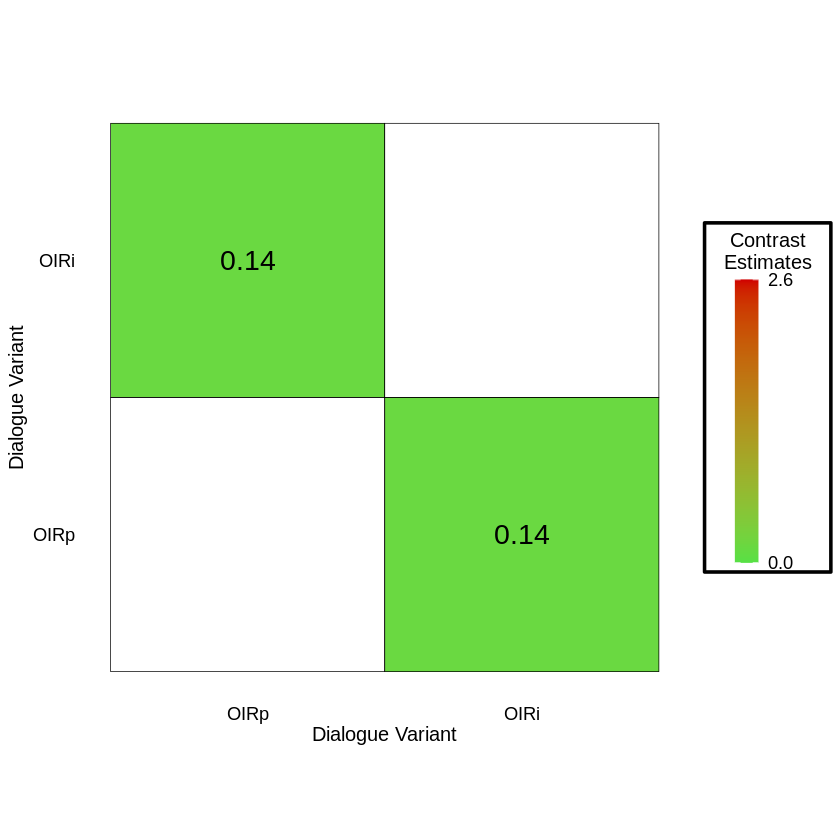

In [22]:
# Split Effect into two conditions
df_heat_coef <- df_pairwise %>%
  mutate(Effect = as.character(Effect)) %>%
  separate(Effect, into = c("Condition1", "Condition2"), sep = " - ") %>%
  rename(Coefficient = Coefficient)

# Get all unique conditions
all_conditions <- unique(c(df_heat_coef$Condition1, df_heat_coef$Condition2))

# Create a full grid of all condition pairs
full_grid <- expand.grid(
  Condition1 = all_conditions,
  Condition2 = all_conditions
)

# Join the actual coefficients onto the grid
df_heat_coef_full <- full_grid %>%
  left_join(df_heat_coef, by = c("Condition1", "Condition2")) %>%
  # Add reversed pairs if missing (for symmetry)
  mutate(
    Coefficient = ifelse(
      is.na(Coefficient),
      df_heat_coef$Coefficient[
        match(
          paste(Condition2, Condition1, sep = "-"),
          paste(df_heat_coef$Condition1, df_heat_coef$Condition2, sep = "-")
        )
      ],
      Coefficient
    )
  )

# Blank out diagonal (self-comparisons)
df_heat_coef_full <- df_heat_coef_full %>%
  mutate(Coefficient = ifelse(Condition1 == Condition2, NA, Coefficient))

# Make factors for axes
df_heat_coef_full <- df_heat_coef_full %>%
  mutate(
    Condition1 = factor(Condition1, levels = all_conditions),
    Condition2 = factor(Condition2, levels = all_conditions)
  )

# Plot heatmap
ggplot(df_heat_coef_full, aes(x = Condition1, y = Condition2, fill = Coefficient)) +
  geom_tile(color = "black") +
  geom_text(aes(label = round(Coefficient, 2)), size = 6, na.rm = TRUE) +
  scale_fill_gradient(
    name = "Contrast\nEstimates",
    low = "#57e145",
    high = "#d00000",
    limits = c(0.0, 2.6),
    breaks = c(0.0, 2.6),
    labels = c("0.0", "2.6"),
    oob = squish,
    na.value = "white"
  ) +
  labs(x = "Dialogue Variant", y = "Dialogue Variant") +
  coord_fixed() +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.title.x = element_text(size = 12, color = "black"),
    axis.title.y = element_text(size = 12, color = "black"),
    axis.text = element_text(size = 11, color = "black"),
    legend.title = element_text(size = 12, hjust = 0.5),
    legend.text = element_text(size = 11),
    legend.background = element_rect(color = "black", size = 1),
    legend.key.height = unit(1.2, "cm"),
    legend.key.width = unit(0.5, "cm"),
    legend.spacing.y = unit(0.2, "cm"),
    legend.position = "right",
    legend.justification = "center"
  )